In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

C:\Users\rs1044\AppData\Local\Temp\ipykernel_23456\2908213944.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq=time_resolution)


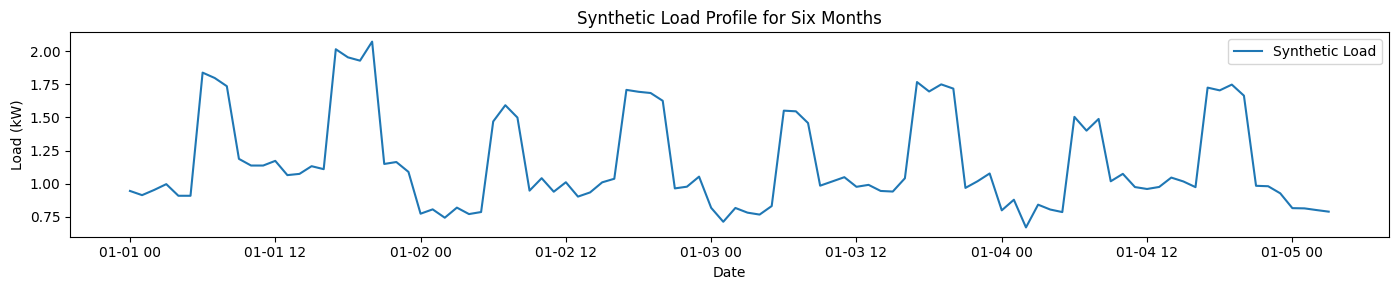

In [2]:
# Parameters
np.random.seed(42)
start_date = '2023-01-01'
end_date = '2023-06-30'
time_resolution = '1H'

# Generate data
date_range = pd.date_range(start=start_date, end=end_date, freq=time_resolution)
load_data = pd.DataFrame(index=date_range)

# Functions to generate base load patterns
def simulate_daily_pattern(index):
    hours = index.hour
    morning_peak = (hours >= 6) & (hours < 9)
    evening_peak = (hours >= 17) & (hours < 21)
    night = (hours >= 0) & (hours < 6)
    base_load = 0.8
    daily_load = base_load + 0.5 * morning_peak + 0.7 * evening_peak - 0.2 * night
    return daily_load

def simulate_weekday_weekend_pattern(index):
    weekdays = index.dayofweek < 5
    weekends = ~weekdays
    weekday_load = 1.0
    weekend_load = 1.2
    load_pattern = weekday_load * weekdays + weekend_load * weekends
    return load_pattern

def simulate_weather_effect(index):
    monthly_avg_temp = {1: 0, 2: 2, 3: 8, 4: 15, 5: 20, 6: 25}
    temperatures = np.array([monthly_avg_temp[month] for month in index.month])
    temp_effect = 0.2 * (temperatures < 5) + 0.3 * (temperatures > 22)
    return temp_effect

# Generate realistic load data
load_data['Base_Load'] = simulate_daily_pattern(load_data.index)
load_data['Weekend_Effect'] = simulate_weekday_weekend_pattern(load_data.index)
load_data['Weather_Effect'] = simulate_weather_effect(load_data.index)
load_data['Synthetic_Load'] = load_data['Base_Load'] * load_data['Weekend_Effect'] + load_data['Weather_Effect']
load_data['Synthetic_Load'] += np.random.normal(0, 0.05, len(load_data))

# Visualization
plt.figure(figsize=(14, 3))
plt.plot(load_data['Synthetic_Load'][:100], label='Synthetic Load')
plt.title('Synthetic Load Profile for Six Months')
plt.xlabel('Date')
plt.ylabel('Load (kW)')
plt.legend()
plt.tight_layout()
plt.show()

# Baseline Estimators

In [3]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import LSTM, Dense
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import lightgbm as lgb

c:\Users\rs1044\Documents\GitHub\Advancing-Flexibility-in-Energy-Grids\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rs1044\Documents\GitHub\Advancing-Flexibility-in-Energy-Grids\.venv\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# Moving average over the past 24 hours
load_data['Moving_Avg_Baseline'] = (load_data['Synthetic_Load'].groupby(load_data.index.hour).apply(lambda x: x.rolling(window=10, min_periods=1).mean()).reset_index(level=0, drop=True))

In [5]:
# ARIMA Model
arima_model = ARIMA(load_data['Synthetic_Load'], order=(1, 1, 1))
arima_fit = arima_model.fit()
load_data['ARIMA_Baseline'] = arima_fit.predict(start=1, end=len(load_data), dynamic=False)

In [6]:
train_size = int(len(load_data)/2)

# Create additional time-based features
load_data['Hour'] = load_data.index.hour
load_data['DayOfWeek'] = load_data.index.dayofweek
load_data['DayOfYear'] = load_data.index.dayofyear

# Prepare the training data with time-based features
train_data = load_data.iloc[:train_size]
test_data = load_data.iloc[train_size:]

# Define X (features) and y (target) for train and test
X_train = train_data[['Hour', 'DayOfWeek', 'DayOfYear']]
y_train = train_data['Synthetic_Load']
X_test = test_data[['Hour', 'DayOfWeek', 'DayOfYear']]

# Use one-hot encoding for categorical features (Hour and DayOfWeek)
preprocessor = ColumnTransformer(
    transformers=[
        ('hour', OneHotEncoder(drop='first'), ['Hour']),
        ('dayofweek', OneHotEncoder(drop='first'), ['DayOfWeek']),
        ('dayofyear', 'passthrough', ['DayOfYear'])
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and the regression model
linear_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

# Fit the model
linear_pipeline.fit(X_train, y_train)

# Predict using the trained model
load_data['Linear_Regression_Baseline'] = linear_pipeline.predict(load_data[['Hour', 'DayOfWeek', 'DayOfYear']])


In [7]:
# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_load = scaler.fit_transform(load_data['Synthetic_Load'].values.reshape(-1, 1))

X = []
y = []
time_steps = 24  # Using the past 24 hours to predict the next hour

for i in range(time_steps, len(scaled_load)):
    X.append(scaled_load[i - time_steps:i, 0])
    y.append(scaled_load[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X, y, epochs=100, batch_size=32, verbose=0)

# Predict and scale back
lstm_predictions = lstm_model.predict(X)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
load_data['LSTM_Baseline'] = np.nan
load_data['LSTM_Baseline'][time_steps:] = lstm_predictions.flatten()

c:\Users\rs1044\Documents\GitHub\Advancing-Flexibility-in-Energy-Grids\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\rs1044\AppData\Local\Temp\ipykernel_23456\1590256938.py:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  load_data['LSTM_Baseline'][time_steps:] = lstm_predictions.flatten()
C:\Users\rs1044\AppData\Local\Temp\ipykernel_23456\159025

In [8]:
# Autoencoder Model
autoencoder_model = Sequential([
    Dense(64, activation='relu', input_shape=(time_steps,)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(time_steps, activation='linear')
])

autoencoder_model.compile(optimizer='adam', loss='mse')
autoencoder_model.fit(X, X, epochs=100, batch_size=32, verbose=0)

# Reconstruct the input to serve as the baseline
autoencoder_predictions = autoencoder_model.predict(X)
autoencoder_predictions = scaler.inverse_transform(autoencoder_predictions)
load_data['Autoencoder_Baseline'] = np.nan
load_data['Autoencoder_Baseline'][time_steps:] = autoencoder_predictions[:, -1]

c:\Users\rs1044\Documents\GitHub\Advancing-Flexibility-in-Energy-Grids\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


C:\Users\rs1044\AppData\Local\Temp\ipykernel_23456\948037041.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  load_data['Autoencoder_Baseline'][time_steps:] = autoencoder_predictions[:, -1]
C:\Users\rs1044\AppData\Local\Temp\ipykernel_23

In [9]:
# Prepare the data for Prophet
load_data_prophet = load_data.reset_index()
load_data_prophet.rename(columns={'index': 'ds', 'Synthetic_Load': 'y'}, inplace=True)

# Initialize the Prophet model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    interval_width=0.95  # 95% confidence intervals
)

# Fit the model
model.fit(load_data_prophet[['ds', 'y']])

# Make future dataframe for forecasting (in-sample)
future = model.make_future_dataframe(periods=0, freq='H')

# Predict the in-sample values
forecast = model.predict(future)

# Add the forecasted values to 'load_data' DataFrame
load_data['Prophet_Forecast'] = forecast['yhat'].values
load_data['Prophet_Lower'] = forecast['yhat_lower'].values
load_data['Prophet_Upper'] = forecast['yhat_upper'].values

00:42:52 - cmdstanpy - INFO - Chain [1] start processing
00:42:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\rs1044\Documents\GitHub\Advancing-Flexibility-in-Energy-Grids\.venv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [10]:
# Define quantiles to predict
quantiles = [0.05, 0.5, 0.95]
models = {}
predictions = {}

# Prepare the data
data = load_data.copy()
data.reset_index(inplace=True)

# Feature Engineering
data['hour'] = data['index'].dt.hour
data['dayofweek'] = data['index'].dt.dayofweek
data['month'] = data['index'].dt.month
data['dayofyear'] = data['index'].dt.dayofyear
data['sin_hour'] = np.sin(2 * np.pi * data['hour']/24)
data['cos_hour'] = np.cos(2 * np.pi * data['hour']/24)
data['sin_dayofweek'] = np.sin(2 * np.pi * data['dayofweek']/7)
data['cos_dayofweek'] = np.cos(2 * np.pi * data['dayofweek']/7)

# Create lag features
for lag in range(1, 25):
    data[f'lag_{lag}'] = data['Synthetic_Load'].shift(lag)

# Drop rows with NaN values due to lagging
data = data.dropna().reset_index(drop=True)

# Define features and target
features = ['hour', 'dayofweek', 'month', 'dayofyear',
            'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek'] + [f'lag_{lag}' for lag in range(1, 25)]
X = data[features]
y = data['Synthetic_Load']

# Train a model for each quantile
for q in quantiles:
    params = {
        'objective': 'quantile',
        'metric': 'quantile',
        'alpha': q,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'verbose': -1
    }
    
    lgb_train = lgb.Dataset(X, y)
    model = lgb.train(params, lgb_train, num_boost_round=200)
    models[q] = model
    pred = model.predict(X)
    data[f'LGBM_Predicted_{int(q*100)}'] = pred

# Map the predictions back to 'load_data'
for q in quantiles:
    col_name = f'LGBM_Predicted_{int(q*100)}'
    load_data[col_name] = np.nan
    load_data.iloc[data.index, load_data.columns.get_loc(col_name)] = data[col_name].values

# Use the predicted quantiles to compute prediction intervals
load_data['LGBM_Lower'] = load_data['LGBM_Predicted_5']
load_data['LGBM_Upper'] = load_data['LGBM_Predicted_95']
load_data['LGBM_Median_Prediction'] = load_data['LGBM_Predicted_50']

In [21]:
def plot_baselines(load_data, start_base, end_base, models_to_plot, color_map):
    # Set up the plot
    plt.figure(figsize=(12, 3))
    
    # Plot each selected model if it exists in the DataFrame
    for model in models_to_plot:
        if model in load_data.columns:
            if model == 'Synthetic_Load':
                # Thicker line for the original data
                plt.plot(load_data.index[start_base:end_base], load_data[model][start_base:end_base],
                         label=model.replace('_', ' '), color=color_map.get(model, 'black'), linewidth=2)
            elif 'Forecast' in model or 'Predicted_50' in model:
                # Plot the forecast
                plt.plot(load_data.index[start_base:end_base], load_data[model][start_base:end_base],
                         label=model.replace('_', ' '), linestyle='--', color=color_map.get(model, 'blue'), linewidth=1)
                # Plot confidence interval if available
                ci_lower = model.replace('Forecast', 'Lower') if 'Forecast' in model else model.replace('Predicted_50', 'Predicted_5')
                ci_upper = model.replace('Forecast', 'Upper') if 'Forecast' in model else model.replace('Predicted_50', 'Predicted_95')
                if ci_lower in load_data.columns and ci_upper in load_data.columns:
                    plt.fill_between(load_data.index[start_base:end_base],
                                     load_data[ci_lower][start_base:end_base],
                                     load_data[ci_upper][start_base:end_base],
                                     color=color_map.get(model + '_Interval', 'skyblue'), alpha=0.3, label=model.replace('_', ' ') + ' CI')
            elif 'Median_Prediction' in model:
                # Plot the median prediction
                plt.plot(load_data.index[start_base:end_base], load_data[model][start_base:end_base],
                         label='Median Prediction', linestyle='--', color=color_map.get(model, 'green'), linewidth=1)
                # Plot confidence interval
                lower_bound = 'LGBM_Lower'
                upper_bound = 'LGBM_Upper'
                plt.fill_between(load_data.index[start_base:end_base],
                                 load_data[lower_bound][start_base:end_base],
                                 load_data[upper_bound][start_base:end_base],
                                 color=color_map.get(model + '_Interval', 'lightgreen'), alpha=0.3, label='Confidence Interval')
            
            else:
                # Other models (if any)
                plt.plot(load_data.index[start_base:end_base], load_data[model][start_base:end_base],
                         label=model.replace('_', ' '), linestyle='--', color=color_map.get(model, 'grey'), alpha=0.7, linewidth=1)
    
    # Plot title and labels
    plt.title('Baseline Estimations vs Synthetic Load', fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Load (kW)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Place legend below the plot
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=4, fontsize=12)
    plt.tight_layout()
    plt.show()

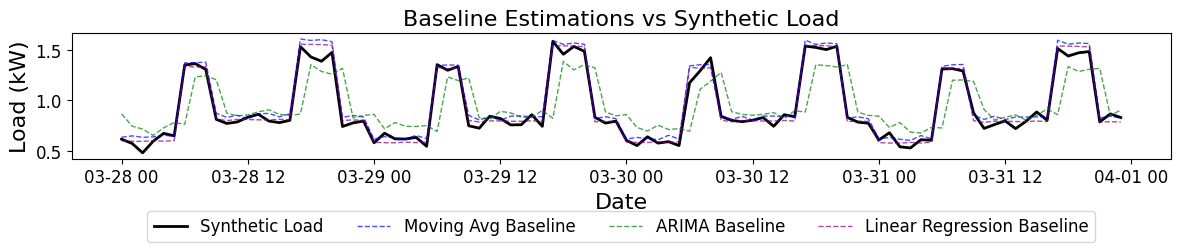

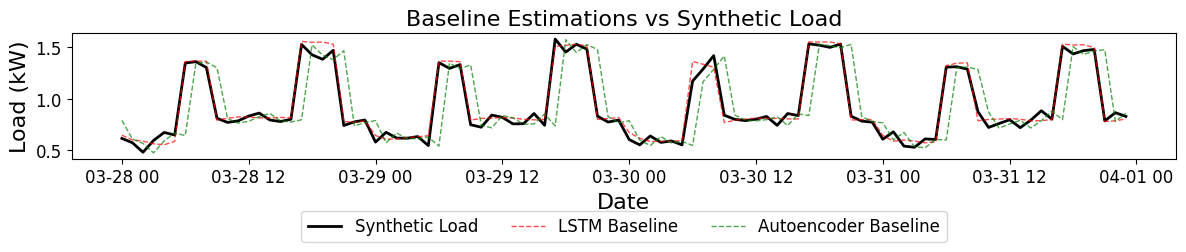

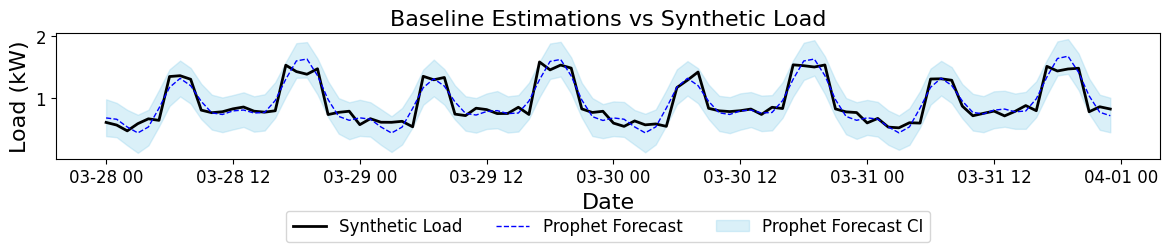

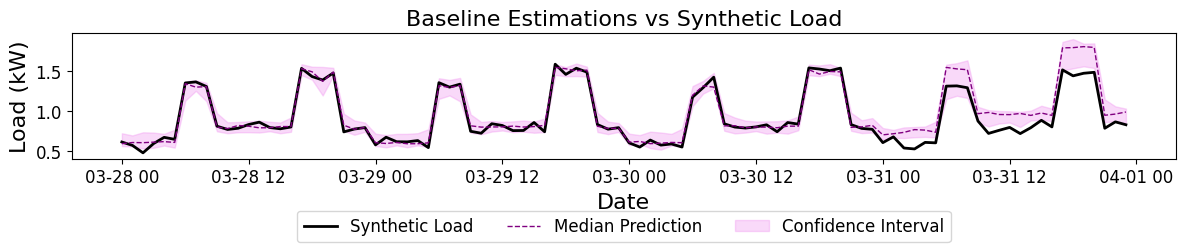

In [22]:
# Example of calling the function
start_base = int(len(load_data) / 2 - 48 * 2)
end_base = int(start_base + 48 * 2)

# Define color mapping for different models
color_map = {
    'Synthetic_Load': 'black',
    'Moving_Avg_Baseline': 'blue',
    'ARIMA_Baseline': 'green',
    'Linear_Regression_Baseline': 'purple',
    'LSTM_Baseline': 'red',
    'Autoencoder_Baseline': 'green',
    'Prophet_Forecast': 'blue',
    'Prophet_Forecast_Interval': 'skyblue',
    'LGBM_Median_Prediction': 'purple',
    'LGBM_Median_Prediction_Interval': 'violet',
}

#All Models: Synthetic_Load, Moving_Avg_Baseline, ARIMA_Baseline, Linear_Regression_Baseline, LSTM_Baseline, Autoencoder_Baseline
models_to_plot=['Synthetic_Load', 'Moving_Avg_Baseline', 'ARIMA_Baseline', 'Linear_Regression_Baseline']

plot_baselines(load_data, start_base, end_base, models_to_plot, color_map)

models_to_plot=['Synthetic_Load', 'LSTM_Baseline', 'Autoencoder_Baseline']

plot_baselines(load_data, start_base, end_base, models_to_plot, color_map)

models_to_plot = ['Synthetic_Load', 'Prophet_Forecast']

plot_baselines(load_data, start_base, end_base, models_to_plot, color_map)

models_to_plot = ['Synthetic_Load', 'LGBM_Median_Prediction']

plot_baselines(load_data, start_base, end_base, models_to_plot, color_map)

# Baseline Shifting

In [13]:
import pandas as pd

def manipulate_load(load_data, congestion_hours, transition_days, total_delta):

    # Ensure the index is datetime
    load_data = load_data.copy()
    load_data.index = pd.to_datetime(load_data.index)

    # Ensure 'Manipulated_Load' exists
    if 'Manipulated_Load' not in load_data.columns:
        load_data['Manipulated_Load'] = load_data['Synthetic_Load'].copy()

    # Get the total length and calculate the index to split data into halves
    total_length = len(load_data)
    second_half_start_index = total_length // 2

    # Get the second half of the data
    second_half_data = load_data.iloc[second_half_start_index:].copy()

    # Extract the date from the index to group by day
    second_half_data['Date'] = second_half_data.index.date

    # Get the list of unique days in the second half
    unique_days = second_half_data['Date'].unique()

    # Define variables
    N_cong_hours = len(congestion_hours)
    N_non_cong_hours = 24 - N_cong_hours

    # Loop over each day in the second half
    for day_num, day in enumerate(unique_days):
        if day_num < transition_days:
            delta_per_day = total_delta * ((day_num + 1) / transition_days)
        else:
            delta_per_day = total_delta

        # Calculate per-hour deltas for congestion and non-congestion hours
        delta_cong_per_hour = delta_per_day / N_cong_hours
        delta_non_cong_per_hour = -delta_per_day / N_non_cong_hours

        # Get data for the current day
        day_data = second_half_data[second_half_data['Date'] == day]

        # Create masks for congestion and non-congestion hours
        hours = day_data.index.hour
        cong_mask = hours.isin(congestion_hours)
        non_cong_mask = ~cong_mask

        # Apply the deltas to 'Manipulated_Load'
        load_data.loc[day_data[cong_mask].index, 'Manipulated_Load'] += delta_cong_per_hour
        load_data.loc[day_data[non_cong_mask].index, 'Manipulated_Load'] += delta_non_cong_per_hour

    # Drop the 'Date' column if it was added to the original DataFrame
    if 'Date' in load_data.columns:
        load_data.drop(columns=['Date'], inplace=True)

    return load_data


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_load_comparison(load_data, manipulated_load_data, congestion_hours, unmanipulated_days=3, manipulated_days=3):

    # Ensure indices are datetime
    load_data = load_data.copy()
    manipulated_load_data = manipulated_load_data.copy()
    load_data.index = pd.to_datetime(load_data.index)
    manipulated_load_data.index = pd.to_datetime(manipulated_load_data.index)
    
    # Determine the point where manipulation starts (second half of the data)
    total_length = len(load_data)
    manipulation_start_index = total_length // 2
    manipulation_start_time = load_data.index[manipulation_start_index]
    
    # Calculate the time range for plotting
    start_time = manipulation_start_time - pd.Timedelta(days=unmanipulated_days)
    end_time = manipulation_start_time + pd.Timedelta(days=manipulated_days)
    
    # Extract the data for the specified time range
    original_plot_data = load_data.loc[start_time:end_time]
    manipulated_plot_data = manipulated_load_data.loc[start_time:end_time]
    
    # Create the plot
    plt.figure(figsize=(15, 4))
    
    # Plot Synthetic_Load
    plt.plot(original_plot_data.index, original_plot_data['Synthetic_Load'], label='Original Load', alpha=0.9, color="#294586")
    
    # Plot Manipulated_Load
    plt.plot(manipulated_plot_data.index, manipulated_plot_data['Manipulated_Load'], label='Manipulated Load', linestyle='--', alpha=0.9, color="#903045")
    
    # Fill the areas where Manipulated_Load > Synthetic_Load with red
    plt.fill_between(manipulated_plot_data.index, manipulated_plot_data['Manipulated_Load'], original_plot_data['Synthetic_Load'], 
                     where=(manipulated_plot_data['Manipulated_Load'] > original_plot_data['Synthetic_Load']), 
                     interpolate=True, color='red', alpha=0.3)
    
    # Fill the areas where Manipulated_Load < Synthetic_Load with grey
    plt.fill_between(manipulated_plot_data.index, manipulated_plot_data['Manipulated_Load'], original_plot_data['Synthetic_Load'], 
                     where=(manipulated_plot_data['Manipulated_Load'] < original_plot_data['Synthetic_Load']), 
                     interpolate=True, color='grey', alpha=0.4)
    
    # Add black vertical line at the manipulation start time
    plt.axvline(manipulation_start_time, color='black', linestyle='--', linewidth=2)
    
    # Highlight congestion hours with yellow background
    # Get the unique dates in the plot range
    plot_dates = pd.date_range(start=start_time.normalize(), end=end_time.normalize())
    
    for single_date in plot_dates:
        for hour in congestion_hours:
            congestion_start = pd.Timestamp(single_date) + pd.Timedelta(hours=hour)
            congestion_end = congestion_start + pd.Timedelta(hours=1)
            # Only highlight if within the plot range
            if congestion_start >= start_time and congestion_end <= end_time:
                plt.axvspan(congestion_start, congestion_end, color='#D7C000', alpha=0.2, lw=0)
    
    # Add labels and legend
    plt.xlabel('Date and Time', fontsize=16)
    plt.ylabel('Load', fontsize=16)
    plt.title(f'Baseline Shifting', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(which='major', color="lightgrey")
    plt.xlim(start_time, end_time)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()


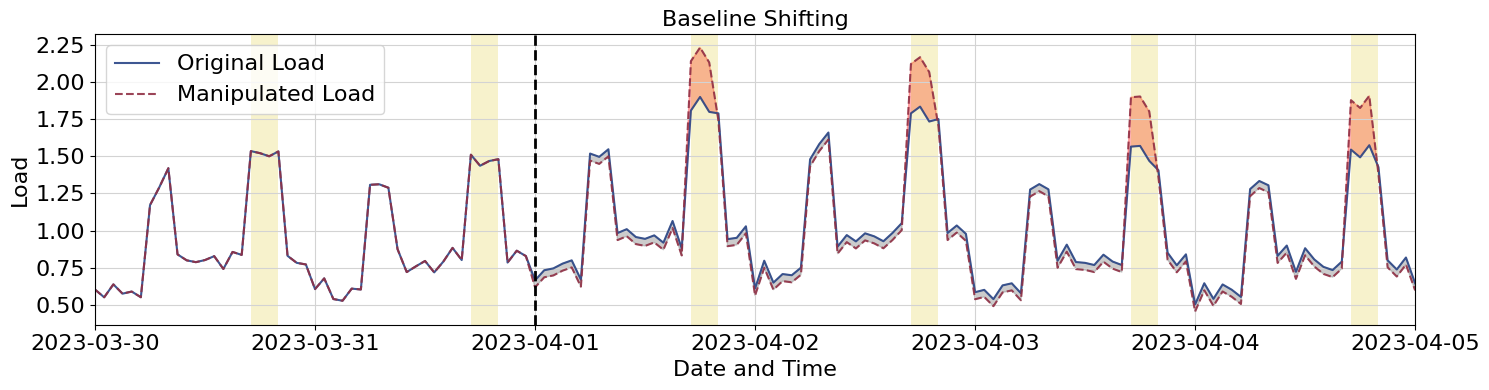

In [15]:
# Assuming you have already manipulated your load data
# Define your parameters
congestion_hours = [17, 18, 19]
transition_days = 1
total_delta = 1.0

# Manipulate the load data using the previously defined function
manipulated_load_data = manipulate_load(load_data, congestion_hours, transition_days, total_delta)

# Plot the comparison
plot_load_comparison(load_data, manipulated_load_data, congestion_hours, unmanipulated_days=2, manipulated_days=4)

